# Zyfra: efficiency solutions for heavy industry.

The main goal of this project is to build a model that will help to predict the amount of gold recovered from gold ore, to the end of optimizing the production and eliminating unprofitable parameters.

For training and testing the model we will use data on extraction and purification. The data is stored in three files:

- gold_recovery_train.csv — training dataset download
- gold_recovery_test.csv — test dataset download
- gold_recovery_full.csv — source dataset download



## Process summary: extracting gold from ore.

Mined ore undergoes primary processing to get the ore mixture or rougher feed, which is the raw material for flotation (also known as the rougher process). After flotation, the material is sent to two-stage purification.


- **1. Flotation**

Gold ore mixture is fed into the float banks to obtain rougher Au concentrate and rougher tails (product residues with a low concentration of valuable metals).
The stability of this process is affected by the volatile and non-optimal physicochemical state of the flotation pulp (a mixture of solid particles and liquid).

- **2. Purification**

The rougher concentrate undergoes two stages of purification. After purification, we have the final concentrate and new tails.

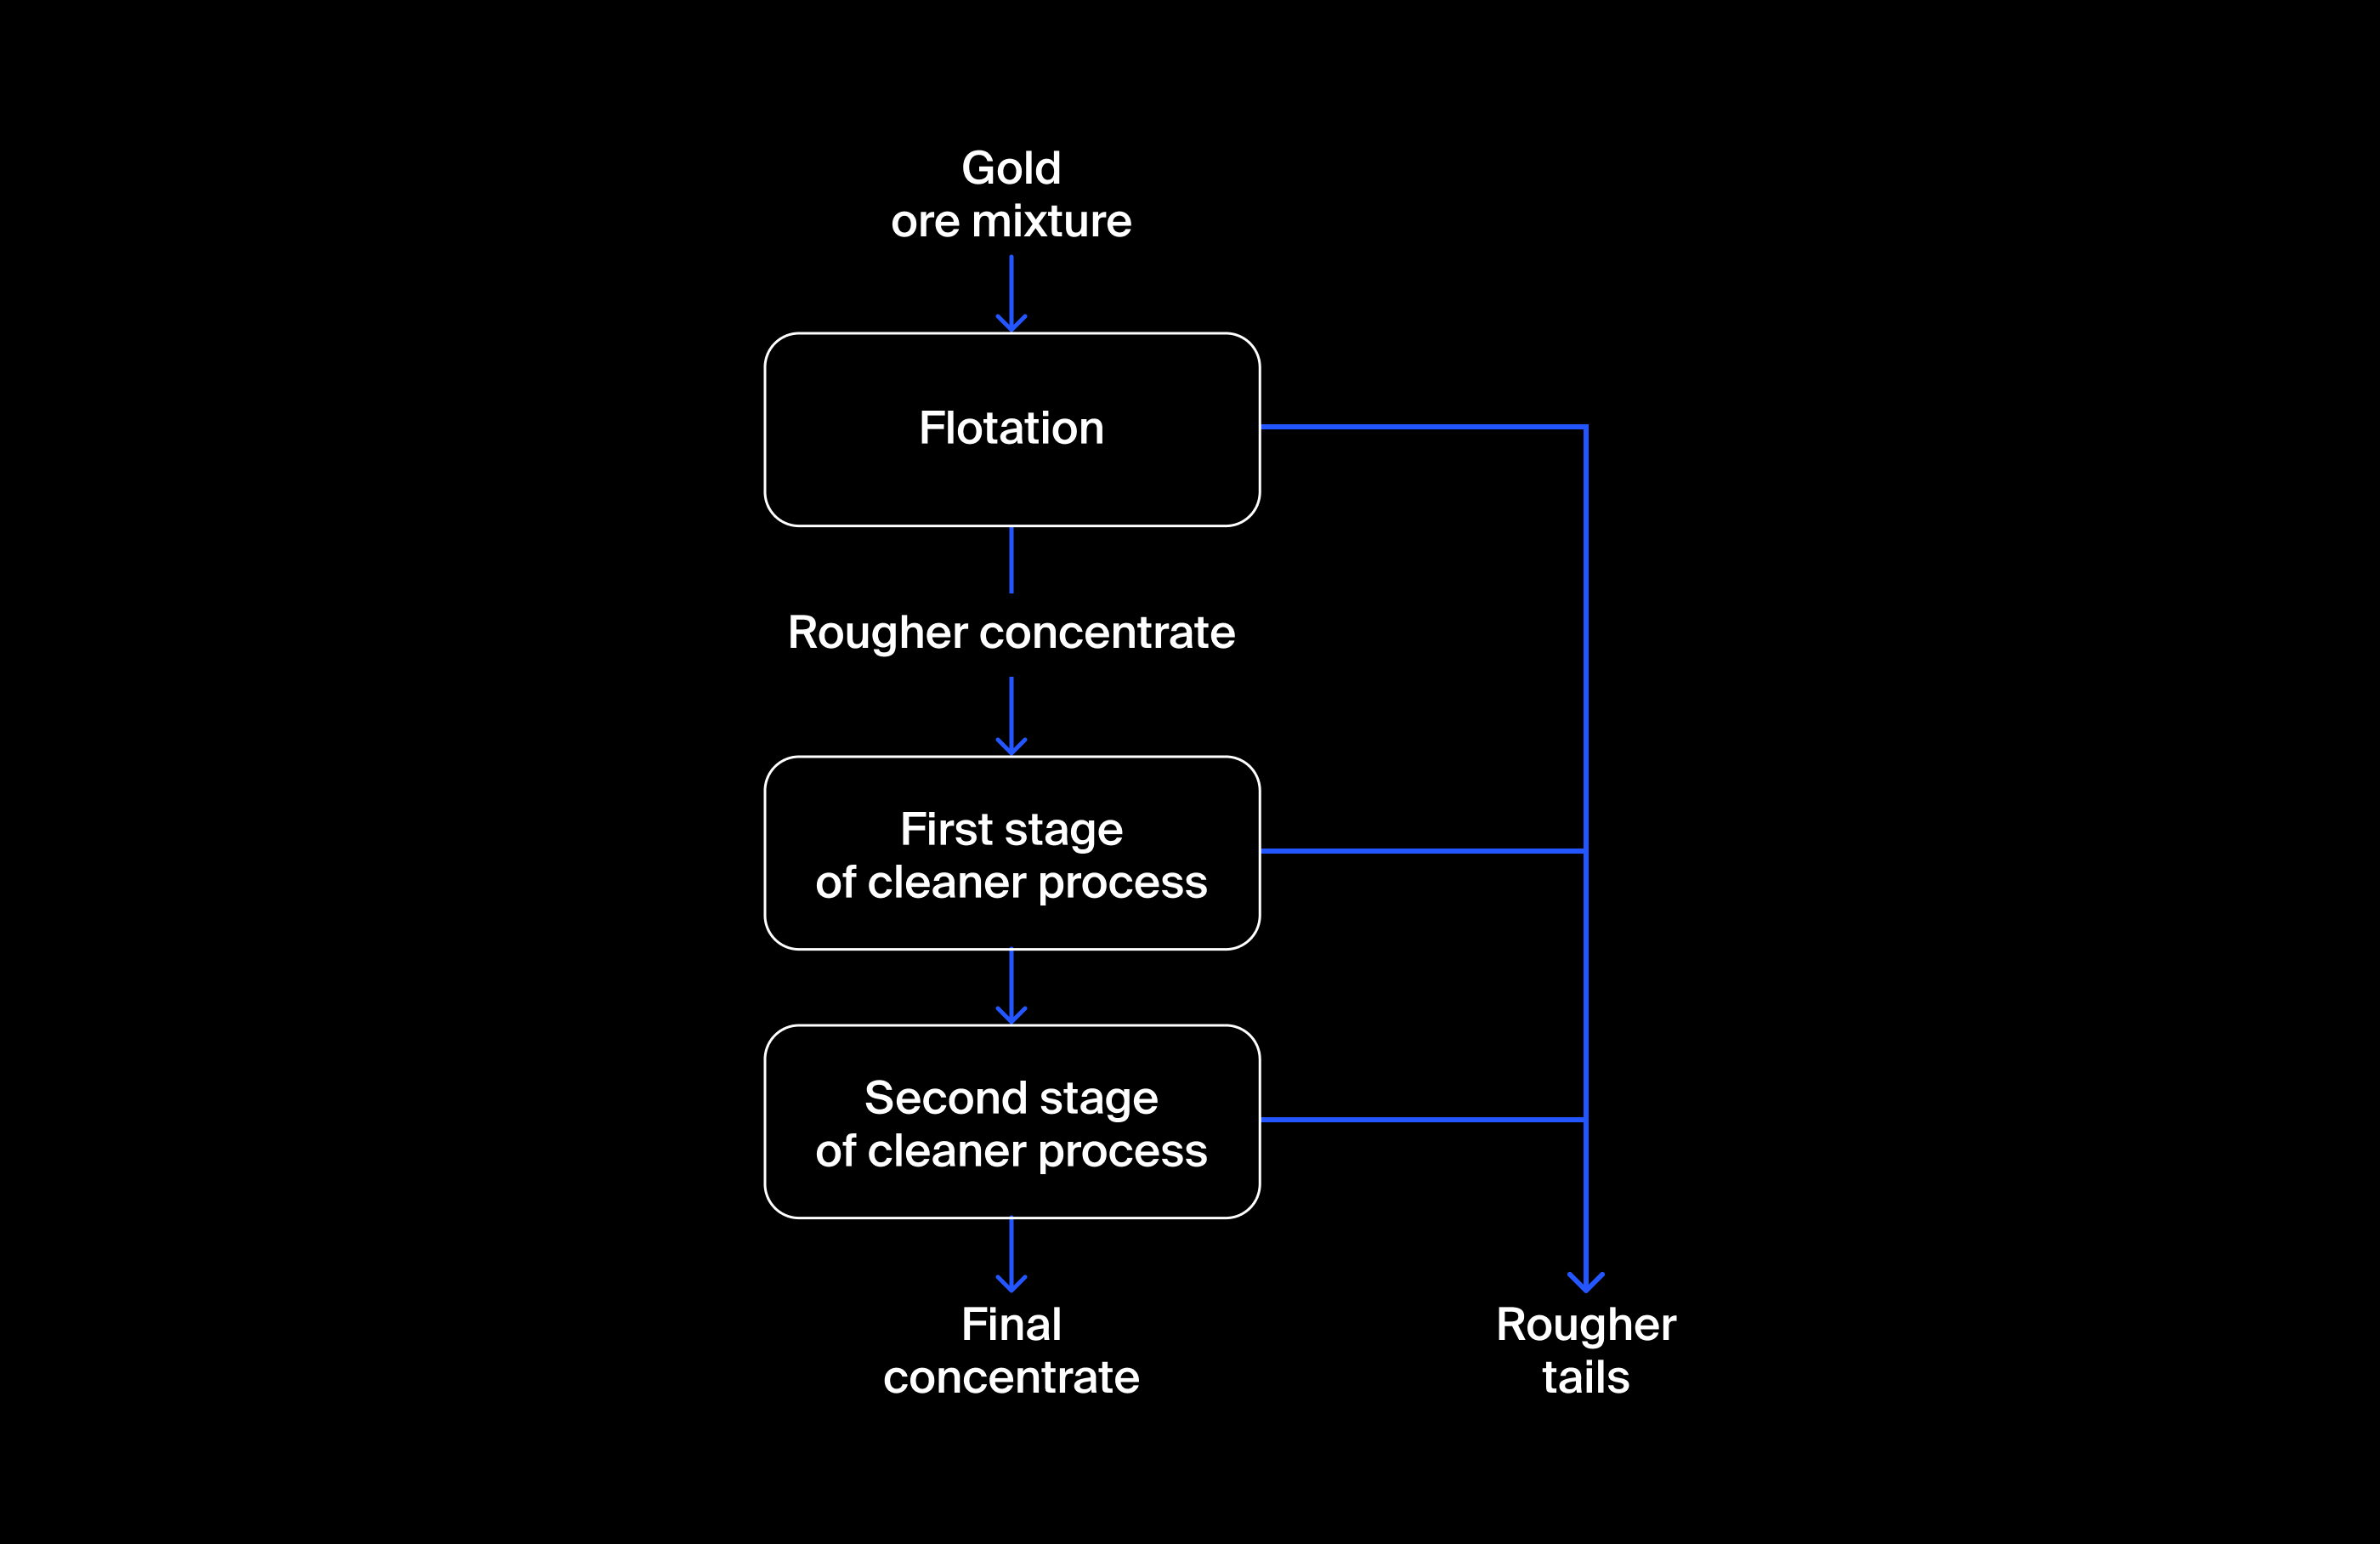



## Data description


**The features are named as follows:**

***[stage].[parameter_type].[parameter_name]***

Example: rougher.input.feed_ag

***Possible values for [stage]:***

- rougher — flotation

- primary_cleaner — primary purification

- secondary_cleaner — secondary purification

- final — final characteristics


***Possible values for [parameter_type]:***

- input — raw material parameters

- output — product parameters

- state — parameters characterizing the current state of the stage

- calculation — calculation characteristics


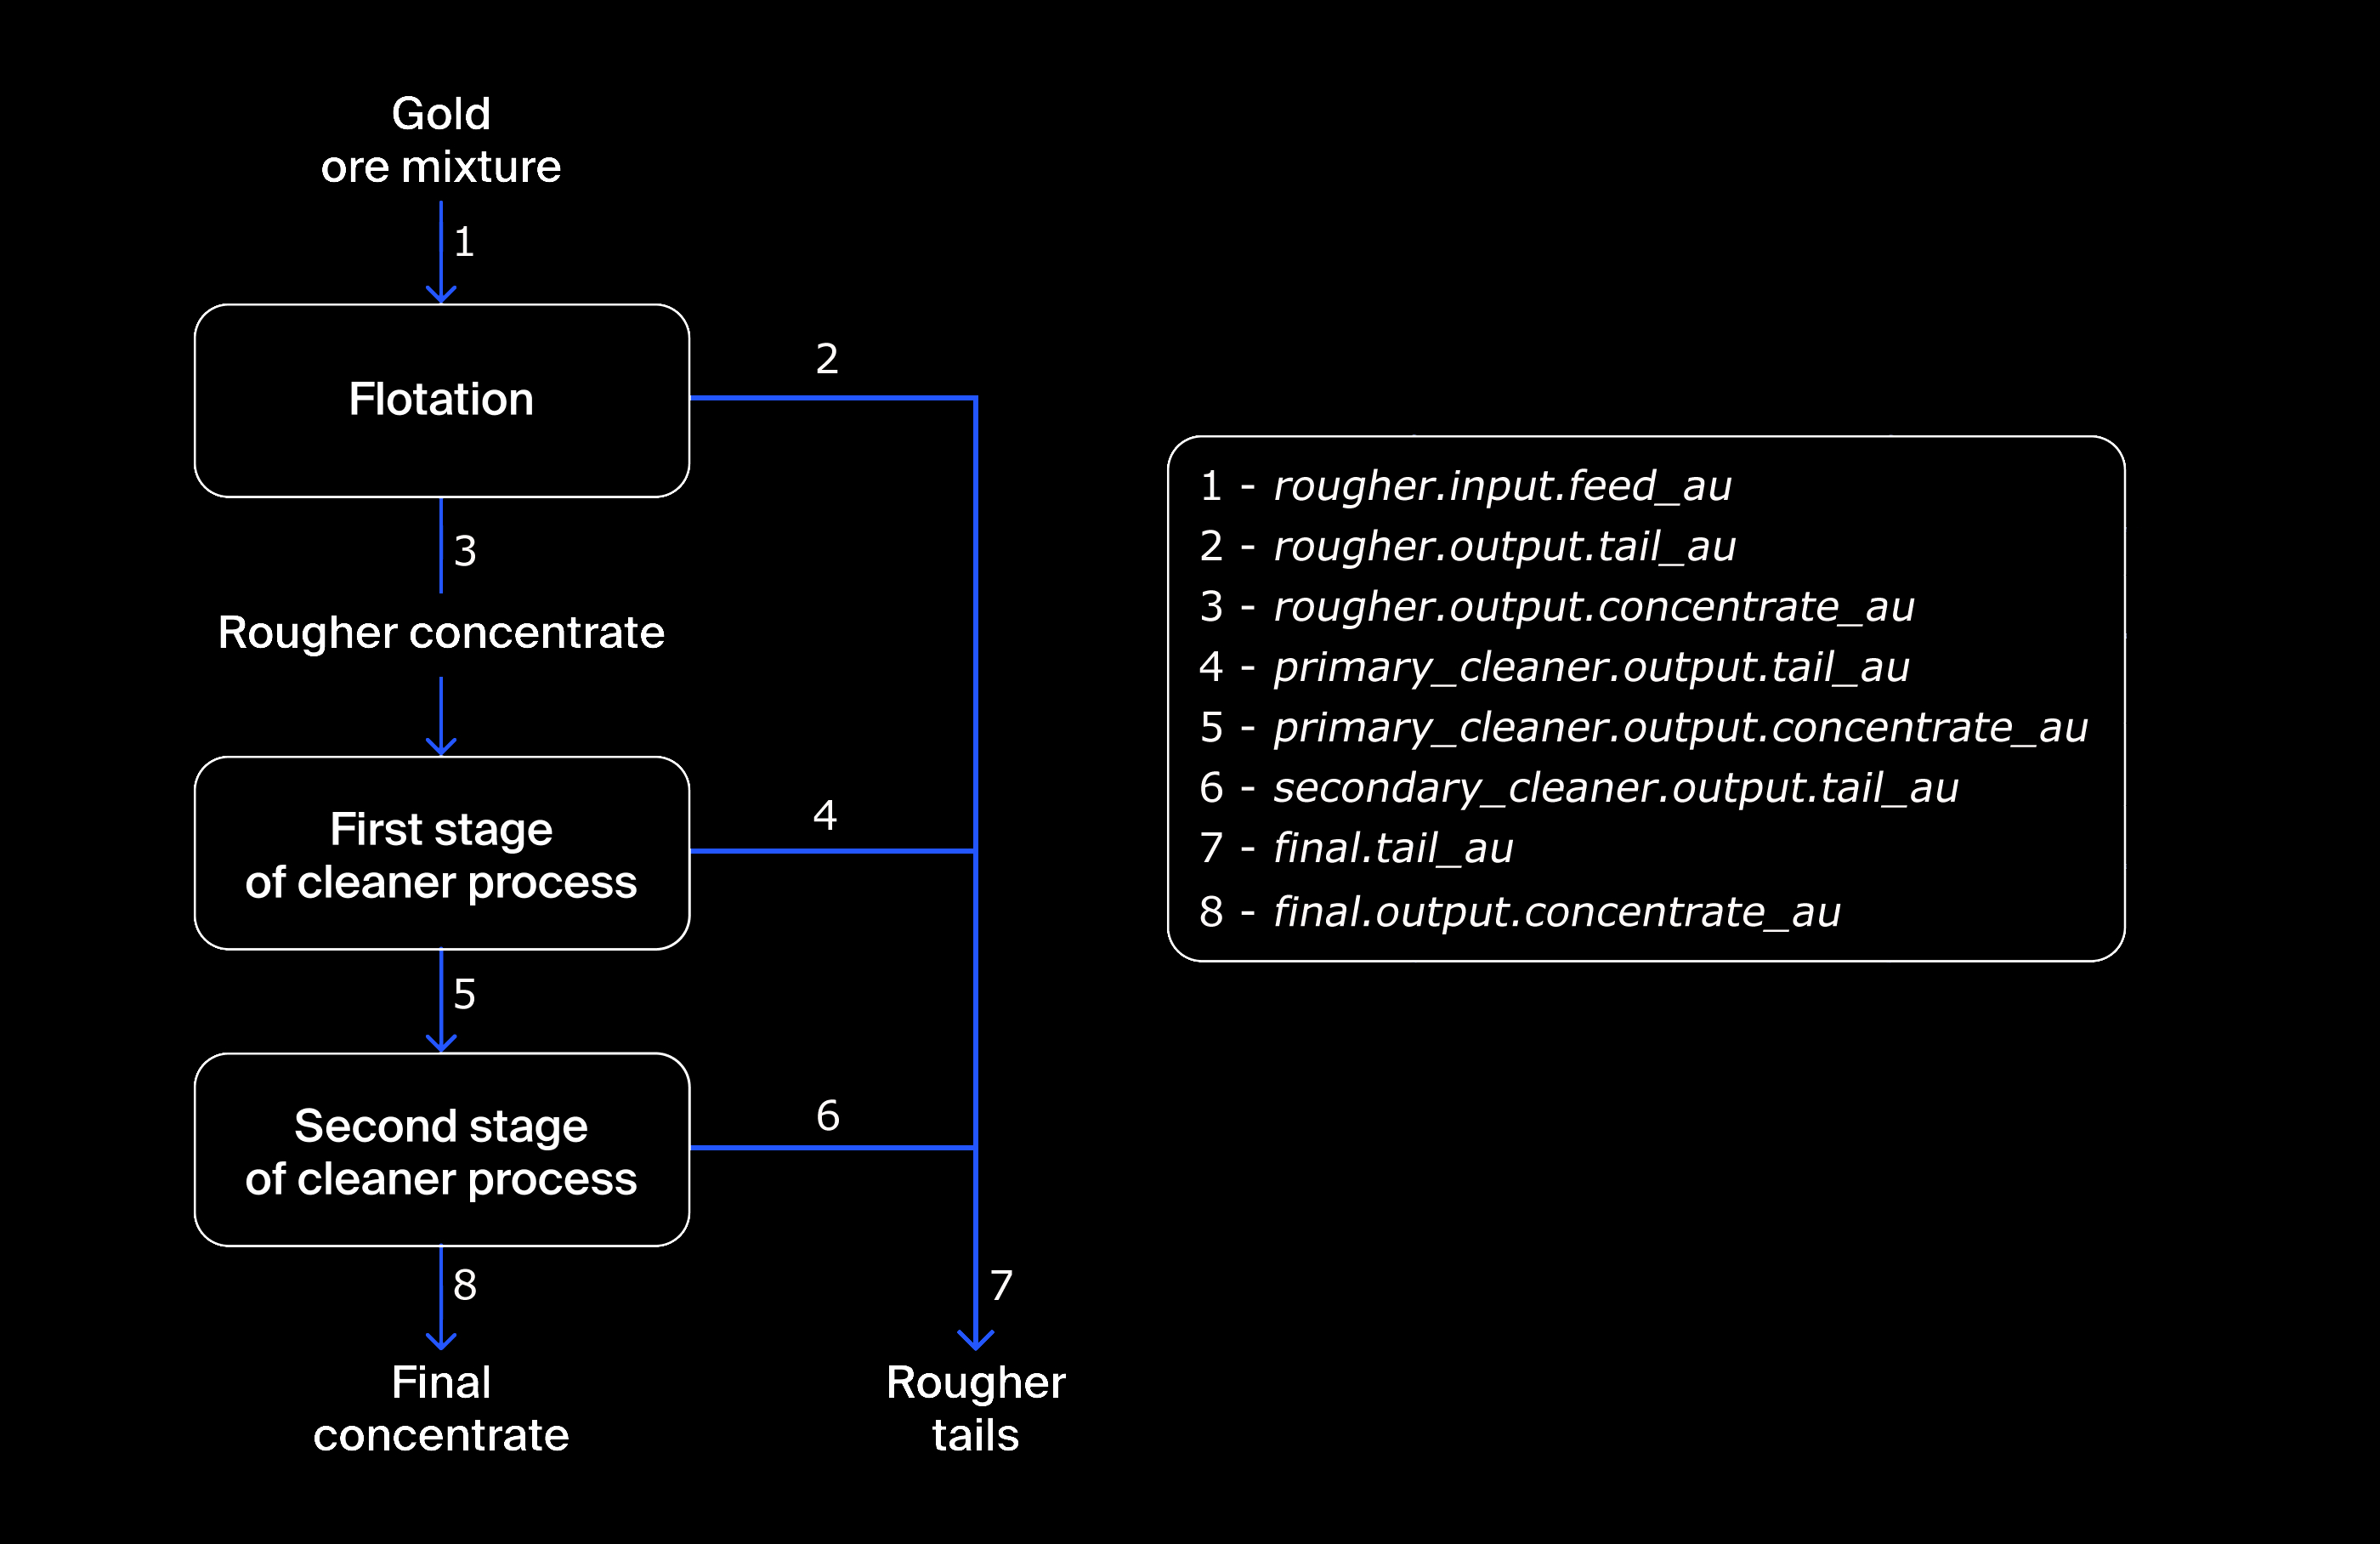

-------------------------------------------------------------------------------------------------------------------------------

**Technological process**

- Rougher feed — raw material

- Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant

- Xanthate — promoter or flotation activator;

- Sulphate — sodium sulphide for this particular process;

- Depressant — sodium silicate.

- Rougher process — flotation

- Rougher tails — product residues

- Float banks — flotation unit
 
- Cleaner process — purification

- Rougher Au — rougher gold concentrate

- Final Au — final gold concentrate


**Parameters of stages**

- air amount — volume of air

- fluid levels

- feed size — feed particle size

- feed rate

-------------------------------------------------------------------------------------------------------------------------------

Data is indexed with the date and time of acquisition (date feature). 

Parameters that are next to each other in terms of time are often similar.

Some parameters are not available because they were measured and/or calculated much later. 

That's why, some of the features that are present in the training set may be absent from the test set. The test set also doesn't contain targets.

The source dataset contains the training and test sets with all the features.

## Recovery calculation: 

The following formula is applied to calculate the recovery:

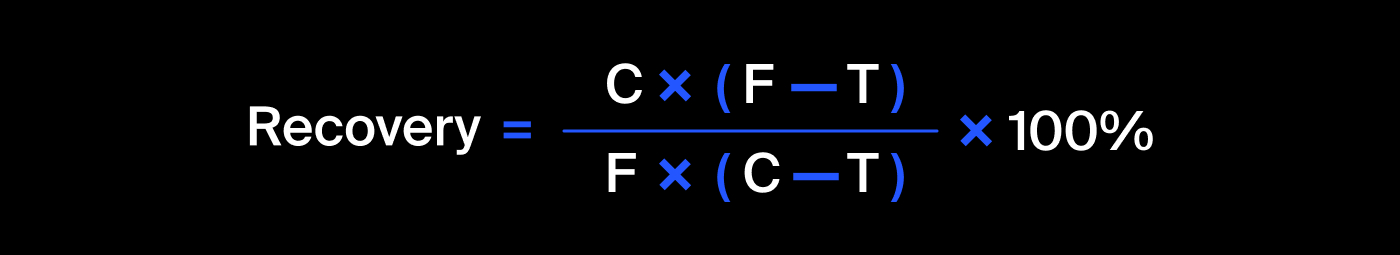


**Where:**

- C : share of gold in the concentrate right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)

- F : share of gold in the feed before flotation (for finding the rougher concentrate recovery)/in the concentrate right after flotation (for finding the final concentrate recovery)

- T : share of gold in the rougher tails right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)

To predict the coefficient, we need to find the share of gold in the concentrate and the tails. Note that both final and rougher concentrates matter.

## Evaluation metric:

To solve the problem, we will use a tailored specific metric. 

It is called sMAPE, symmetric Mean Absolute Percentage Error.

It is similar to MAE, but is expressed in relative values instead of absolute ones. It is symmetrical because it equally takes into account the scale of both the target and the prediction.

Here’s how sMAPE is calculated:

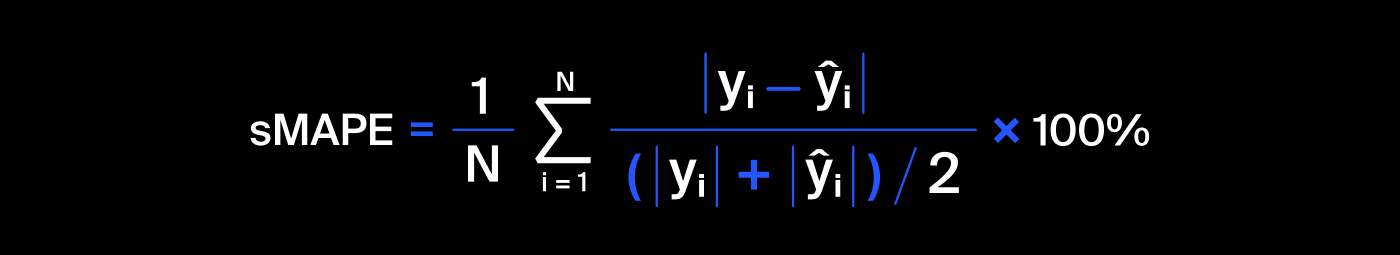

Denotation:


- Yi: Value of target for the observation with the i index in the sample used to measure quality.

- ^yi:  Value of prediction for the observation with the i index, for example, in the test sample.

- N: Number of observations in the sample.

- E: Summation over all observations of the sample (i takes values from 1 to N).


We need to predict two values:

- rougher concentrate recovery rougher.output.recovery

- final concentrate recovery final.output.recovery

The final metric includes the two values:

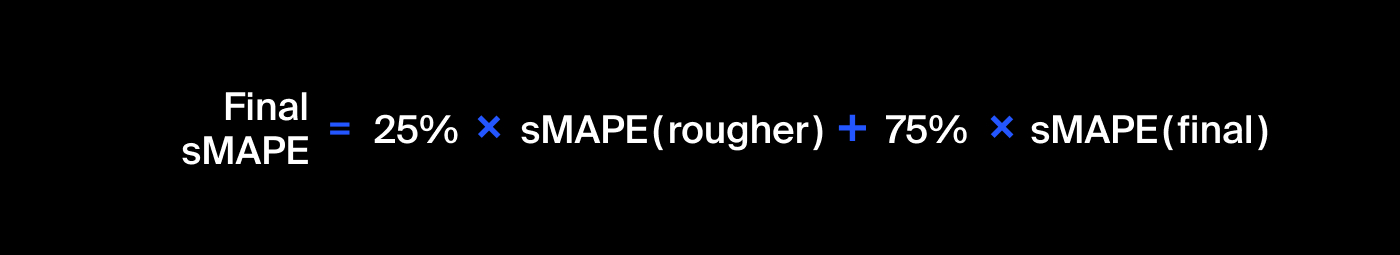


## Steps to choose the best model:

To the aim of properly training and selecting the model, we will:

1) Prepare the data:

- 1.1. Open the files and look into the data.
    
- 1.2. Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between our calculations and the feature values.
    
- 1.3. Analyze the features not available in the test set. Find out if there are any patterns in the parameters type.
    
- 1.4. Perform data preprocessing.

2) Analyze the data

- 2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

- 2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.

- 2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate:

    - Detect any abnormal values in the total distribution.
    - If anomalies are found, analyze if is it worth removing such values from both samples. 
    - Eliminate anomalies, if proceeding


3) Build the model

- 3.1. Write a function to calculate the final sMAPE value.

- 3.2. Train different models, evaluate them using cross-validation and pick the best model. Then, test it using the test sample.






In [1]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor

## 1) Prepare the data:

### 1.1. Open the files and look into the data.

In [2]:
# Load datasets into Dataframes
try:
    full_df=pd.read_csv('c:/Users/josef/Practicum/Integrated Project 2/gold_recovery_full.csv')
except:
    full_df=pd.read_csv('/datasets/gold_recovery_full.csv')
    

In [3]:
# Load datasets into Dataframes
try:
    test_df=pd.read_csv('c:/Users/josef/Practicum/Integrated Project 2/gold_recovery_test.csv')
except:
    test_df=pd.read_csv('/datasets/gold_recovery_test.csv')
    

In [4]:
# Load datasets into Dataframes
try:
    train_df=pd.read_csv('c:/Users/josef/Practicum/Integrated Project 2/gold_recovery_train.csv')
except:
    train_df=pd.read_csv('/datasets/gold_recovery_train.csv')
    

In [5]:
#print target distribution
full_df['final.output.recovery'].describe()

count    20753.000000
mean        67.447488
std         11.616034
min          0.000000
25%         63.282393
50%         68.322258
75%         72.950836
max        100.000000
Name: final.output.recovery, dtype: float64

In [6]:
#print target distribution
full_df['rougher.output.recovery'].describe()

count    19597.000000
mean        83.078122
std         14.661880
min          0.000000
25%         80.941306
50%         86.144121
75%         89.987561
max        100.000000
Name: rougher.output.recovery, dtype: float64

In [7]:
#Print first five rows - full df
full_df.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [8]:
#Print info - full df
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [9]:
#Print first five rows - train df
train_df.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [10]:
#Print info - train df
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [11]:
#Print first five rows - test df
test_df.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [12]:
#Print info - full df
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [13]:
#Print percentage of rows with missing values in at least one column in full df

(len(full_df)-len(full_df.dropna()))/len(full_df)*100

29.15125902447614

In [14]:
#Print percentage of rows with missing values in at least one column in train df

(len(train_df)-len(train_df.dropna()))/len(train_df)*100

34.655990510083036

In [15]:
#Print percentage of rows with missing values in at least one column in test df

(len(test_df)-len(test_df.dropna()))/len(test_df)*100

8.077185792349727

In [16]:
#find duplicated rows in full df
full_df.duplicated().sum()

0

In [17]:
#find duplicated dates in full df
full_df['date'].duplicated().sum()

0

In [18]:
#find duplicated rows in train df
train_df.duplicated().sum()

0

In [19]:
#find duplicated dates in train df
train_df['date'].duplicated().sum()

0

In [20]:
#find duplicated rows in test df
test_df.duplicated().sum()

0

In [21]:
#find duplicated dates in test df
test_df['date'].duplicated().sum()

0

## Overview conclusions

From an overall data view, we can tell that:

- 1) Columns are correctly named, using lowercase characters and with no spacing between words. 

- 2) There are no duplicated rows or dates.

- 3) The only data type to be changed is that of the "date" column (from object to datetime) as the rest of them were imported as float type.

- 4) The are many missing values in multiple columns (29% of rows from the full dataset have missing values in at least one column - 34% and 8% in the train and test datasets, respectively). We know from the description that parameters that are next to each other in terms of time are often similar, so we'll fill out missing values with the immediately previous observation.

- 5) The test set has 53 columns, whereas the train and full set have 87. We'll print out these parameters and analyze their type.


Next steps will be:

- 1.2) Recalculate recovery for the rougher stage, compare it to the rougher.output.recovery feature and get the mean absolute error between both.

- 1.3)  Analyze the features not available in the test set.

- 1.4) Change date column type to datetime and convert it to the index of every dataframe.

- 1.5) Fix missing values


### 1.2. Recalculate recovery 

Using the training set, we'll calculate recovery for the rougher.output.recovery and final.output.recovery features. 

Then we'll find the MAE between our calculations and the feature values.

***Rougher output recovery***

In [22]:
#Print columns containing "au" in description to find the names of the ones we'll use for recovery calculation
au_columns=[col for col in train_df.columns if 'au' in col]
au_columns

['final.output.concentrate_au',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.input.feed_au',
 'rougher.output.concentrate_au',
 'rougher.output.tail_au',
 'secondary_cleaner.output.tail_au']

In [23]:
#Create a dataframe with the features of interest

recovery_rec_df= train_df[['rougher.input.feed_au','rougher.output.concentrate_au','rougher.output.tail_au','rougher.output.recovery']].copy()

In [24]:
#Print first five rows

recovery_rec_df.head()

,rougher.input.feed_au,rougher.output.concentrate_au,rougher.output.tail_au,rougher.output.recovery
0,6.486150,19.793808,1.170244,87.107763
1,6.478583,20.050975,1.184827,86.843261
2,6.362222,19.737170,1.162562,86.842308
3,6.118189,19.320810,1.079755,87.226430
4,5.663707,19.216101,1.012642,86.688794


In [25]:
#Print missing values 

recovery_rec_df.isna().sum()

rougher.input.feed_au              83
rougher.output.concentrate_au      82
rougher.output.tail_au           2249
rougher.output.recovery          2573
dtype: int64

In [26]:
#Discard rows with missing values
recovery_rec_df.dropna(inplace=True)

#add a column with recovery calculation as detailed in the formula
recovery_rec_df['recovery']= recovery_rec_df.apply(lambda x: round((x['rougher.output.concentrate_au']*(x['rougher.input.feed_au']-x['rougher.output.tail_au']))/(x['rougher.input.feed_au']*(x['rougher.output.concentrate_au']-x['rougher.output.tail_au'])),6)*100, axis=1).copy()

In [27]:
#get the absolute dif between calculated recovery and target column
recovery_rec_df['abs_dif'] = recovery_rec_df.apply(lambda x: abs(x['rougher.output.recovery']-x['recovery']), axis=1)

In [28]:
#calculate the mean of the abs dif column
mae=round(recovery_rec_df['abs_dif'].mean(),2)
mae

0.0

In [29]:
#double-check using mae formula
recovery_mae= round(mean_absolute_error(recovery_rec_df['rougher.output.recovery'],recovery_rec_df['recovery']),2)
recovery_mae

0.0

***Final output recovery***

In [30]:
def final_recovery(df):
    C = df['final.output.concentrate_au']
    F = df['rougher.input.feed_au']
    T = df['final.output.tail_au']
    if (F*(C-T)) !=0:
        final_rec= 100*C*(F-T) / (F*(C-T))
    else:
        final_rec=0
    
    return final_rec


In [31]:
#Create a dataframe with the features of interest

final_recovery_rec_df= train_df.copy()

In [32]:
#Discard rows with missing values
final_recovery_rec_df.dropna(inplace=True)

#add a column with recovery calculation as detailed in the formula
final_recovery_rec_df['final_recovery']= final_recovery_rec_df.apply(final_recovery, axis=1).copy()

In [33]:
#get the absolute dif between calculated recovery and target column
final_recovery_rec_df['abs_dif'] = final_recovery_rec_df.apply(lambda x: abs(x['final.output.recovery']-x['final_recovery']), axis=1)

In [34]:
#calculate the mean of the abs dif column
mae=round(final_recovery_rec_df['abs_dif'].mean(),2)
mae

0.0

### Conclusion

The rougher.output.recovery and final.output.recovery features are accurately calculated

### 1.3. Analyze the features not available in the test set. 

Check what these parameters are, and what's their type.



In [35]:
#Save missing col names in list
test_missing_col = [col for col in full_df.columns if col not in test_df.columns]

#check that it worked
len(test_missing_col)+len(test_df.columns)-len(full_df.columns)

0

In [36]:
#print missing column names
test_missing_col

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

### Conclusion

The missing columns correspond either to outputs, or calculation columns. Recall that some parameters are not available because they were measured and/or calculated much later.

That's why, some of the features that are present in the training set are absent from the test set. The test set also doesn't contain targets.

What this means, is that at the time of using our model in the future for predicting the amount of gold that will be recovered  from ore, those observations won't be available. Hence, we need to train and evaluate models' perfomance, without including those. For the sake of comparing predictions to real results, can still get the missing observations for calculating recovery, provided that the source dataset contains the training and test sets with all the features.


Following steps will consist of:

- First, we'll change date column to datetime.

- Then we'll fill out the missing values in the source set using the immediately previous value available (forward fill) in every column except for rougher.output.recovery and final.output.recovery, which will be calculated once every other value is filled out, using the corresponding formula, and compared to the values we'd have got through forward fill. If the MAE between them is trivial, we'll use either of both methods to fill missing values, since they'd corroborate the theory of the formula inputs being similar in contiguous days. Otherwise, we'll drop out the rows where either of the targets is missing.



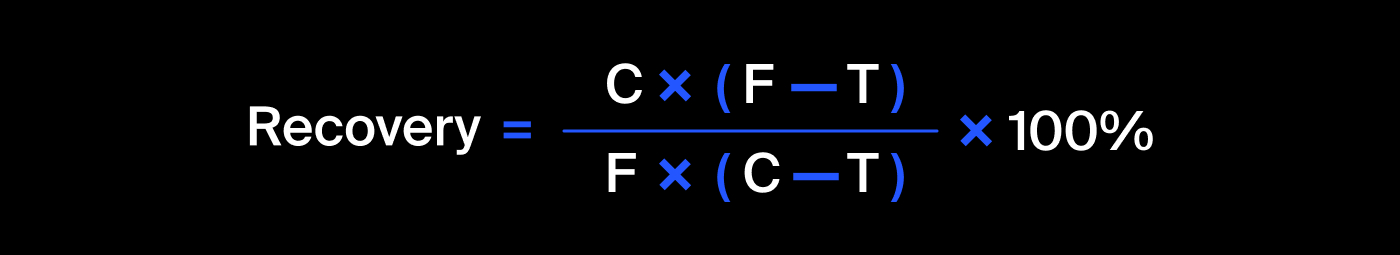


**Where:**

- C : share of gold in the concentrate right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)

- F : share of gold in the feed before flotation (for finding the rougher concentrate recovery)/in the concentrate right after flotation (for finding the final concentrate recovery)

- T : share of gold in the rougher tails right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)



- Finally, we will set date column as index in all dataframes and reassign the features and target without any missing values to each date index in the test and training set.

### 1.4) Change date column type to datetime.

In [37]:
#change date type to datetime
full_df['date']= pd.to_datetime(full_df['date'])
test_df['date']= pd.to_datetime(test_df['date'])
train_df['date']= pd.to_datetime(train_df['date'])

### 1.5) Fix missing values

We will fill missing values in the source set, in every column other than 'rougher.output.recovery' and 'final.output.recovery'.

Then we'll calculate rougher and final recovery in rows where it's missing and compare it to the values obtained with forward filling to decide on whether to drop rows where the target is missing, or to fill them out with the calculated value (provided that the MAE between them is low enough to conclude that values in contiguous days don't vary significantly).



In [38]:
#Store name of every column except for final and rougher recovery
columns_to_fill= [col for col in full_df if 'rougher.output.recovery' not in col and 'final.output.recovery' not in col]
len(columns_to_fill)

85

In [39]:
#use fill forward to fix missing values in the source dataset

#sort by index (date) in ascending order
full_df.sort_values(by='date',inplace=True)

#fill missing values with ffill method, excluding recovery columns, which will be calculated manually once every value is filled
full_df[columns_to_fill] = full_df[columns_to_fill].fillna(method='ffill').copy()

#Check sum of missing values
print(full_df.isna().sum().sum())
full_df.isna().sum().sum()/len(full_df)

5082


0.2237189646064448

In [40]:
#Verify that they are only located in rougher recovery column
full_df.isna().sum()[full_df.isna().sum()>0]

final.output.recovery      1963
rougher.output.recovery    3119
dtype: int64

In [41]:
#check % of missing values
full_df.isna().sum()[full_df.isna().sum()>0]/len(full_df)

final.output.recovery      0.086415
rougher.output.recovery    0.137304
dtype: float64

  
<div class="alert alert-info">

Before filling out missing values in recovery calculation, we'll calculate the mae between our re-calculations of each missing value and 0, and between re-calculations and forward filled values.
    
</div>

In [42]:

#Recalculate mae between calculated recovery and 0 where it's missing

#Create list with indexes of rows where recovery is missing
indexes_missing_recovery=full_df[pd.isnull(full_df['rougher.output.recovery'])].index


#create new df = full df
dummy_df= full_df.copy()


#ffill recovery missing values

dummy_df['rougher.output.recovery'].fillna(method='ffill', inplace=True)

#restrict df to indexes of missing values

dummy_df_mae= dummy_df.iloc[indexes_missing_recovery].copy()

dummy_df_mae.reset_index(inplace=True, drop=True)

dummy_df_mae['recalculated_recovery']=0


#loop through each row
for i in range(len(dummy_df_mae)):
    

        
    #If the denominator is not 0
    if (dummy_df_mae.loc[i,'rougher.input.feed_au']*(dummy_df_mae.loc[i,'rougher.output.concentrate_au']-dummy_df_mae.loc[i,'rougher.output.tail_au'])) != 0:
        #calculate recovery using the formula
        dummy_df_mae.loc[i,'recalculated_recovery']= round((dummy_df_mae.loc[i,'rougher.output.concentrate_au']*(dummy_df_mae.loc[i,'rougher.input.feed_au']-dummy_df_mae.loc[i,'rougher.output.tail_au']))/(dummy_df_mae.loc[i,'rougher.input.feed_au']*(dummy_df_mae.loc[i,'rougher.output.concentrate_au']-dummy_df_mae.loc[i,'rougher.output.tail_au'])),6)*100
    else:
        #if the denominator is zero, use 0 for the recovery
        dummy_df_mae.loc[i,'recalculated_recovery']= 0


#get the absolute dif between calculated recovery and recovery obtained with ffill
dummy_df_mae['abs_dif'] = dummy_df_mae.apply(lambda x: abs(x['rougher.output.recovery']-x['recalculated_recovery']), axis=1)



#calculate the mean of the abs dif column
mae_recovery_ffill=round(dummy_df_mae['abs_dif'].mean(),2)

#calculate mae between calculated recovery and zeros:

mae_recovery_zeros= abs(dummy_df_mae['recalculated_recovery']).mean()


print('In rows where rougher recovery was missing, MAE between recalculated recovery (using the formula) and the one obtained using forward fill was', mae_recovery_ffill )
print('MAE between recalculated recovery (using the formula) and zero values was', mae_recovery_zeros)

In rows where rougher recovery was missing, MAE between recalculated recovery (using the formula) and the one obtained using forward fill was 334.87
MAE between recalculated recovery (using the formula) and zero values was 327.30419759538273


In [43]:

#Recalculate mae between calculated recovery and 0 where it's missing

#Create list with indexes of rows where recovery is missing
indexes_missing_recovery=full_df[pd.isnull(full_df['final.output.recovery'])].index


#create new df = full df
dummy_df= full_df.copy()


#ffill recovery missing values

dummy_df['final.output.recovery'].fillna(method='ffill', inplace=True)

#restrict df to indexes of missing values

dummy_df_mae= dummy_df.iloc[indexes_missing_recovery].copy()

dummy_df_mae.reset_index(inplace=True, drop=True)

dummy_df_mae['recalculated_recovery']= dummy_df_mae.apply(final_recovery, axis=1)


#get the absolute dif between calculated recovery and recovery obtained with ffill
dummy_df_mae['abs_dif'] = dummy_df_mae.apply(lambda x: abs(x['final.output.recovery']-x['recalculated_recovery']), axis=1)



#calculate the mean of the abs dif column
mae_recovery_ffill=round(dummy_df_mae['abs_dif'].mean(),2)

#calculate mae between calculated recovery and zeros:

mae_recovery_zeros= abs(dummy_df_mae['recalculated_recovery']).mean()


print('In rows where final recovery was missing, MAE between recalculated recovery (using the formula) and the one obtained using forward fill was', mae_recovery_ffill )
print('MAE between recalculated final recovery (using the formula) and zero values was', mae_recovery_zeros)

In rows where final recovery was missing, MAE between recalculated recovery (using the formula) and the one obtained using forward fill was 377.01
MAE between recalculated final recovery (using the formula) and zero values was 325.7921443005399


In [44]:

#drop rows where recovery is missing

full_df.dropna(axis=0, inplace=True)
full_df.reset_index(inplace=True, drop=True)
full_df


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19434,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
19435,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
19436,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
19437,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


Finally, we'll set the date as index and re-distribute the source set without missing values into test and train sets, respecting the same indexes and features.

In [45]:
#Set date column as index
full_df.set_index('date', inplace=True)
train_df.set_index('date', inplace=True)
test_df.set_index('date', inplace=True)

In [46]:
#store indexes of each set, and features available in test dataframe
train_df_dates=[index for index in train_df.index if index in full_df.index]
test_df_dates= [index for index in test_df.index if index in full_df.index]
test_df_features= test_df.columns

In [47]:
#Print shape before re-assigning df
train_df.shape

(16860, 86)

In [48]:
#Print shape before re-assigning df
test_df.shape

(5856, 52)

In [49]:
#Redefine train df filtering the same dates in full df (where missing values have been filled out)
train_df=full_df.loc[train_df_dates,:].copy()
train_df.shape

(14149, 86)

In [50]:
#Check there's no further missing values
train_df.isna().sum().sum()

0

In [51]:
#Redefine test df filtering the same dates in full df (where missing values have been filled out)
test_df=full_df.loc[test_df_dates,test_df_features].copy()
test_df.shape

(5290, 52)

In [52]:
#Check there's no further missing values
test_df.isna().sum().sum()

0

Missing values have been properly fulfilled with the immediately preeceding values in the source set, and reassigned to the test and train sets based on the original datetimes distribution.



## 2) Analyze the data:


### 2.1.Visualize how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.




In [53]:
#print name of columns corresponding to metals concentration
concentration_cols_au= [col for col in full_df.columns if ('concentrate' in col )and ('output' in col ) and('au' in col )]
concentration_cols_au.sort(reverse=True)
concentration_cols_ag= [col for col in full_df.columns if ('concentrate' in col )and ('output' in col ) and('ag' in col )]
concentration_cols_ag.sort(reverse=True)
concentration_cols_pb= [col for col in full_df.columns if ('concentrate' in col )and ('output' in col ) and('pb' in col )]
concentration_cols_pb.sort(reverse=True)
concentration_cols= concentration_cols_au+concentration_cols_ag+concentration_cols_pb

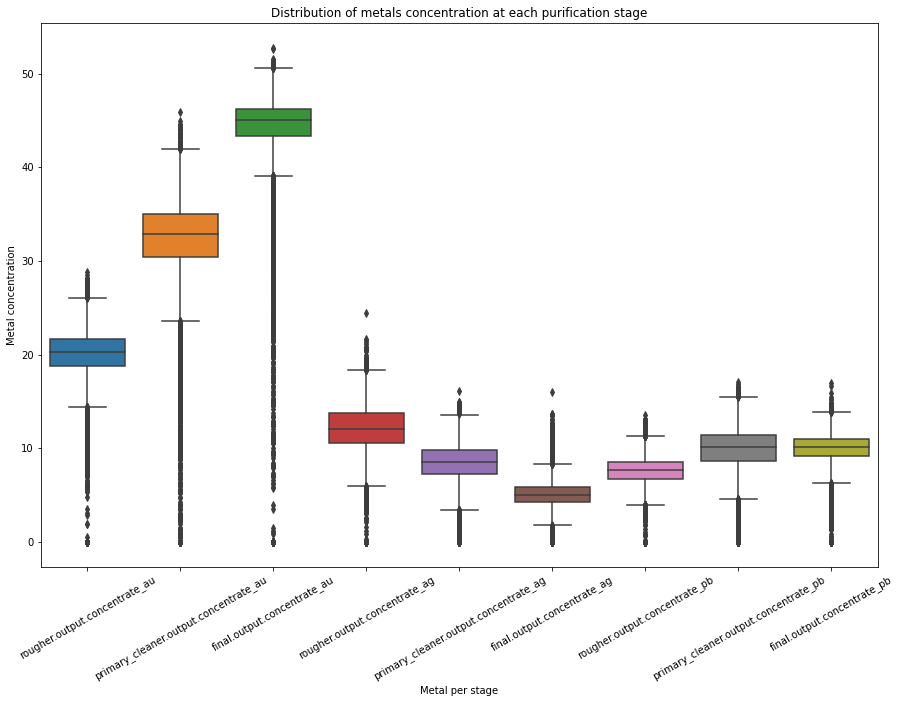

In [54]:

#PLot distribution of metal concentration at each purification stage
plt.figure(figsize=(15,10))
sns.boxplot(data=full_df[concentration_cols])
plt.xticks(rotation=30)

plt.title('Distribution of metals concentration at each purification stage')
plt.xlabel('Metal per stage')
plt.ylabel('Metal concentration');
plt.show()

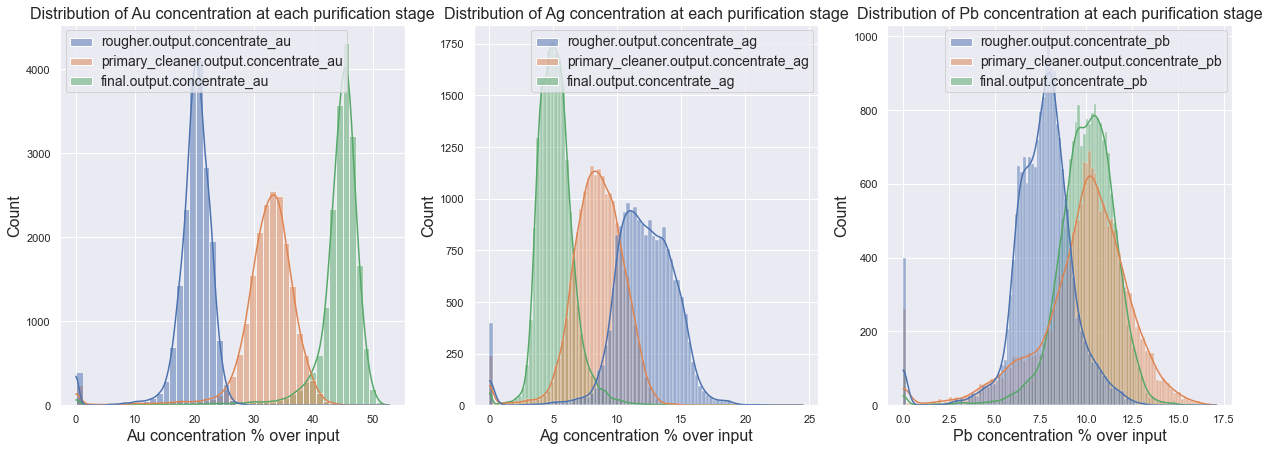

In [55]:
# Draw histogram with density for Au

sns.set( rc = {'figure.figsize' : ( 20, 20 ), 'axes.labelsize' : 16, 'axes.titlesize':16}) 
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

sns.histplot(ax=ax[0],data=full_df[concentration_cols_au], kde=True)

ax[0].set_title('Distribution of Au concentration at each purification stage')
plt.setp(ax[0].get_legend().get_texts(), fontsize='14')
ax[0].set_xlabel('Au concentration % over input')
ax[0].set_ylabel('Count');


# Draw histogram with density for Ag
sns.histplot(ax=ax[1],data=full_df[concentration_cols_ag], kde=True)

ax[1].set_title('Distribution of Ag concentration at each purification stage')
plt.setp(ax[1].get_legend().get_texts(), fontsize='14')
ax[1].set_xlabel('Ag concentration % over input')
ax[1].set_ylabel('Count');


# Draw histogram with density for Pb
sns.histplot(ax=ax[2],data=full_df[concentration_cols_pb], kde=True)

ax[2].set_title('Distribution of Pb concentration at each purification stage')
plt.setp(ax[2].get_legend().get_texts(), fontsize='14')
ax[2].set_xlabel('Pb concentration % over input')
ax[2].set_ylabel('Count');


Taking into consideration the boxplots and the histograms with density estimation, we conclude that:

- As we move down the process pipeline, gold percentage (output/input) tends to increase (distributed closely around the 20% in the rougher stage, and around the 45% in the final stage), but silver percentage tends to decrease. Most days, Ag % recovered throughout the final stage was around 5% whereas in the rougher stage it had been between 10 and 17%. 

- Pb (Lead) % is lower at the rougher stage(between 5% and 10%), and similar in the primary and final stages (between 7.5 and 12.5%)

- There was a considerably high count of days (2500) where metal recovery was close to the 0% at one or more process stages


### 2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.


In [56]:
#print columns showing particles size
[col for col in full_df.columns if 'size' in col]

['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

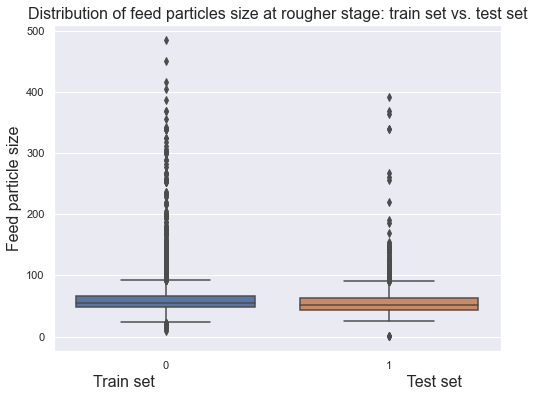

In [57]:

#PLot distribution of feed particle size for the test and train set at the rougher stage
plt.figure(figsize=(8,6))

sns.boxplot(data=[train_df['rougher.input.feed_size'],test_df['rougher.input.feed_size']])

plt.title('Distribution of feed particles size at rougher stage: train set vs. test set')
plt.xlabel('Train set                                                        Test set')
plt.ylabel('Feed particle size');
plt.show()

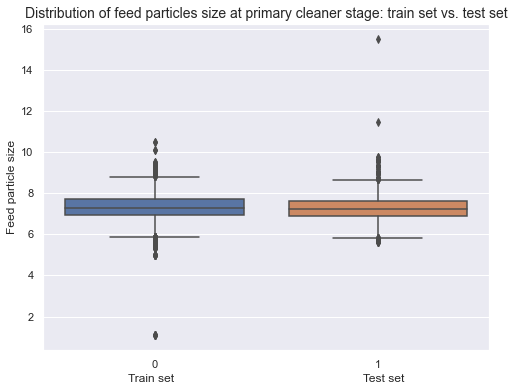

In [58]:
sns.set( rc = {'figure.figsize' : ( 10, 8 ), 'axes.labelsize' : 12, 'axes.titlesize':14}) 
#PLot distribution of feed particle size for the test and train set at the primary cleaner stage
plt.figure(figsize=(8,6))
sns.boxplot(data=[train_df['primary_cleaner.input.feed_size'],test_df['primary_cleaner.input.feed_size']])

plt.title('Distribution of feed particles size at primary cleaner stage: train set vs. test set')
plt.xlabel('Train set                                                        Test set')
plt.ylabel('Feed particle size');
plt.show()

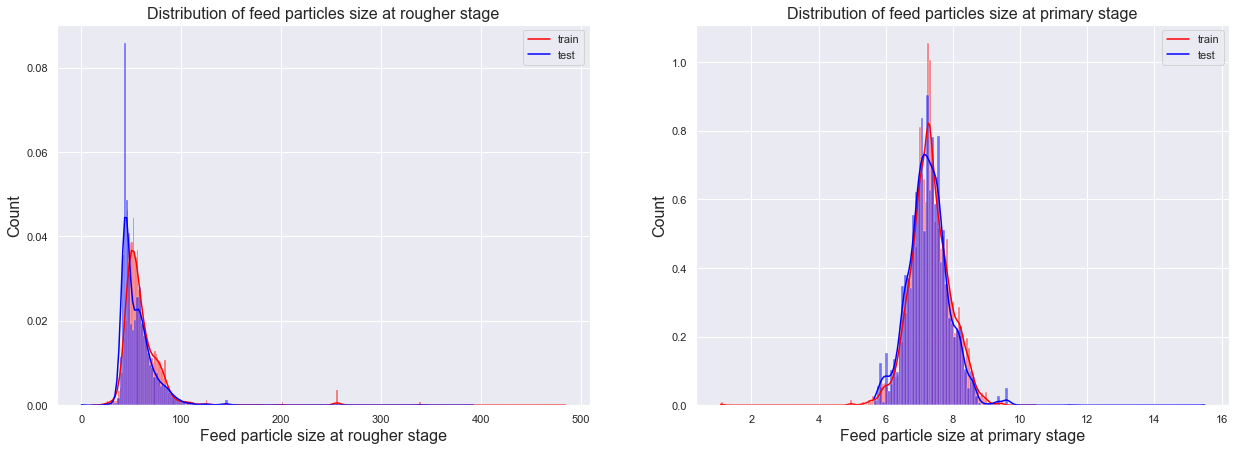

In [59]:
sns.set( rc = {'figure.figsize' : ( 20, 20 ), 'axes.labelsize' : 16, 'axes.titlesize':16}) 
fig, ax = plt.subplots(1, 2, figsize=(21, 7))

# Draw histogram with density for rougher feed particle sized
sns.histplot(ax=ax[0],data=train_df['rougher.input.feed_size'], kde=True, color='red', stat='density')

sns.histplot(ax=ax[0],data=test_df['rougher.input.feed_size'], kde=True,color='blue', stat='density').legend(['train','test'])
ax[0].set_title('Distribution of feed particles size at rougher stage')

ax[0].set_xlabel('Feed particle size at rougher stage')
ax[0].set_ylabel('Count');


# Draw histogram with density for Ag

sns.histplot(ax=ax[1],data=train_df['primary_cleaner.input.feed_size'], kde=True,color='red', stat='density')
sns.histplot(ax=ax[1],data=test_df['primary_cleaner.input.feed_size'], kde=True, color='blue', stat='density').legend(['train','test'])
ax[1].set_title('Distribution of feed particles size at primary stage')

ax[1].set_xlabel('Feed particle size at primary stage')
ax[1].set_ylabel('Count');



From the plots above we can grant that, even though there are some outliers, the feed particle size at rougher and primary stage are similarly distributed in the train and test sets.

### 2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. 

- Detect any abnormal values in the total distribution.
- If anomalies are found, analyze if is it worth removing such values from both samples. 
- Eliminate anomalies, if proceeding


In [60]:
#Print statistics for raw feed concentration
full_df[[col for col in full_df.columns if 'rougher.input.feed_' in col and 'rate' not in col and 'size' not in col]].describe()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_au
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,8.794927,3.584975,36.664846,8.266097
std,1.936847,1.063279,5.200311,1.955092
min,0.010000,0.010000,0.000000,0.010000
25%,7.237967,2.872178,34.194233,6.854384
50%,8.593574,3.528235,37.191868,8.125839
75%,10.213771,4.241005,40.026614,9.769917
max,14.596026,7.142594,53.477742,13.731330


In [61]:
#add up concentration of all substances in a separate column
full_df['raw_feed.concentration']= full_df.apply(lambda x : x['rougher.input.feed_ag']+x['rougher.input.feed_pb']+x['rougher.input.feed_sol']+x['rougher.input.feed_au'], axis=1)

In [62]:
# Print statistics of concentration of all substances
full_df['raw_feed.concentration'].describe()

count    19439.000000
mean        57.310846
std          7.243999
min          0.040000
25%         53.556969
50%         57.591781
75%         61.952764
max         76.978947
Name: raw_feed.concentration, dtype: float64

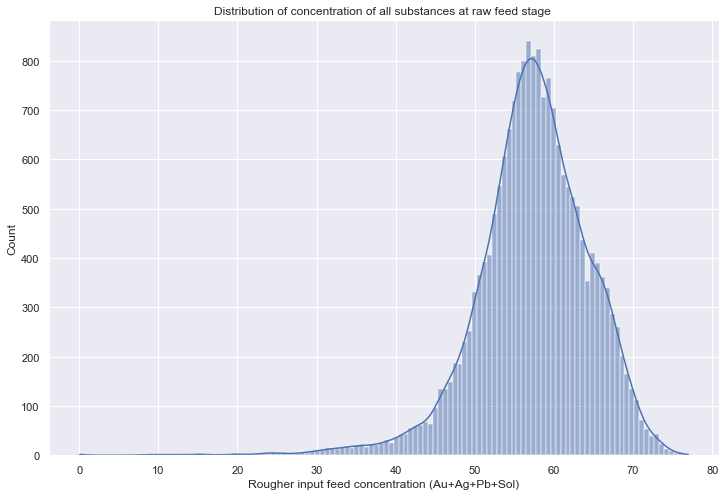

In [63]:
# Plot histogram with raw feed concentrations
sns.set( rc = {'figure.figsize' : ( 12, 8 ), 'axes.labelsize' : 12, 'axes.titlesize':12}) 
ax= sns.histplot(data=full_df['raw_feed.concentration'], kde=True)

ax.set_title('Distribution of concentration of all substances at raw feed stage ')

ax.set_xlabel('Rougher input feed concentration (Au+Ag+Pb+Sol)')
ax.set_ylabel('Count');


In [64]:
#Print statistics for rougher concentration
full_df[[col for col in full_df.columns if 'rougher.output.concentrate' in col]].describe()

,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,11.994759,7.606272,28.788495,19.772000
std,2.733862,1.796757,5.980042,3.753600
min,0.000000,0.000000,0.000000,0.000000
25%,10.628337,6.725987,27.218878,18.802523
50%,12.098115,7.742580,29.833254,20.280214
75%,13.736996,8.565199,32.188259,21.717843
max,24.480271,13.617072,38.351193,28.824507


In [65]:
#add up concentration of all substances at rougher.output stage in a separate column
full_df['rougher_output.concentration']= full_df.apply(lambda x : x['rougher.output.concentrate_ag']+x['rougher.output.concentrate_pb']+x['rougher.output.concentrate_sol']+x['rougher.output.concentrate_au'], axis=1)

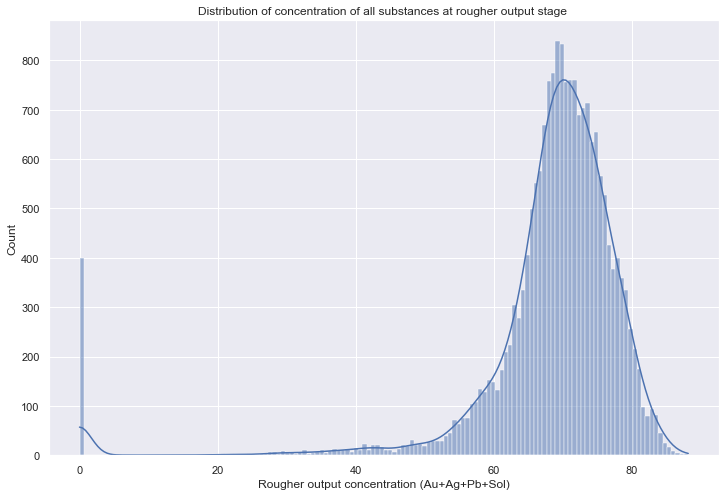

In [66]:

# Plot histogram with rougher output concentrations
sns.set( rc = {'figure.figsize' : ( 12, 8 ), 'axes.labelsize' : 12, 'axes.titlesize':12}) 
ax= sns.histplot(data=full_df['rougher_output.concentration'], kde=True)

ax.set_title('Distribution of concentration of all substances at rougher output stage ')

ax.set_xlabel('Rougher output concentration (Au+Ag+Pb+Sol)')
ax.set_ylabel('Count');



In [67]:
#Print statistics for final output concentration
full_df[[col for col in full_df.columns if 'final.output.concentrate' in col]].describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,5.168387,9.978821,9.422110,44.076513
std,1.372362,1.669228,2.883040,5.129784
min,0.000000,0.000000,0.000000,0.000000
25%,4.251000,9.137225,7.662953,43.402215
50%,5.066039,10.102264,9.184826,45.011244
75%,5.895401,11.035644,10.920957,46.275313
max,16.001945,17.031899,19.615720,52.756638


In [68]:
#add up concentration of all substances at final.output stage in a separate column
full_df['final_output.concentration']= full_df.apply(lambda x : x['final.output.concentrate_ag']+x['final.output.concentrate_pb']+x['final.output.concentrate_sol']+x['final.output.concentrate_au'], axis=1)

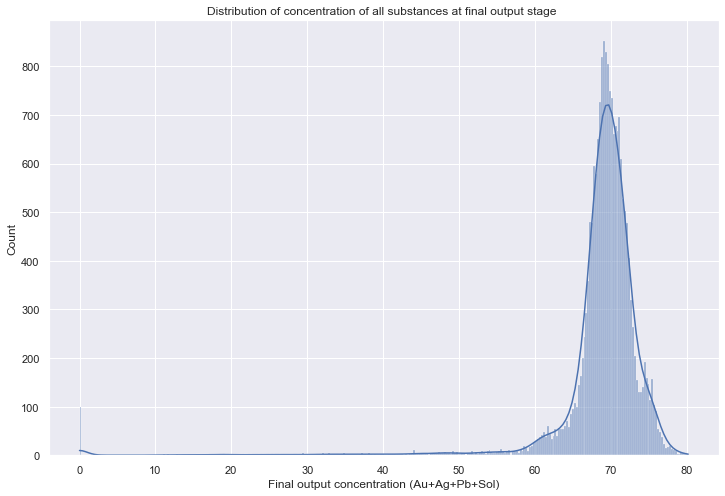

In [69]:
# Plot histogram with final output concentrations
sns.set( rc = {'figure.figsize' : ( 12, 8 ), 'axes.labelsize' : 12, 'axes.titlesize':12}) 
ax= sns.histplot(data=full_df['final_output.concentration'], kde=True)

ax.set_title('Distribution of concentration of all substances at final output stage ')

ax.set_xlabel('Final output concentration (Au+Ag+Pb+Sol)')
ax.set_ylabel('Count');


At rougher and final output stage there are around 400 and 100 observations (respectively) where the sum of concentration of all metals is close to 0. This is considered an anomaly that is worth correcting, due to the large proportion of data that is affected. We will print an overview of rougher.output.recovery and final.output.recovery values in rows where the total concentration of metals at each stage is less than 1, as well as the percentage of the dataset those rows represent, in order to decide how to proceed with them.

In [70]:
#PRINT PERCENTAGE OF ROWS WHERE THE TOTAL CONCENTRATION OF ALL SUBSTANCES IS <1 AT RAW FEED STAGE
len(full_df.loc[full_df['raw_feed.concentration']<1])/len(full_df)

0.00025721487730850353

In [71]:
#PRINT PERCENTAGE OF ROWS WHERE THE TOTAL CONCENTRATION OF ALL SUBSTANCES IS <1 AT ROUGHER OUTPUT STAGE
len(full_df.loc[full_df['rougher_output.concentration']<1])/len(full_df)

0.02052574720921858

In [72]:
#PRINT PERCENTAGE OF ROWS WHERE THE TOTAL CONCENTRATION OF ALL SUBSTANCES IS <1 AT FINAL OUTPUT STAGE
len(full_df.loc[full_df['final_output.concentration']<1])/len(full_df)

0.005092854570708369

In [73]:
#PRINT PERCENTAGE OF ROWS WHERE THE TOTAL CONCENTRATION OF ALL SUBSTANCES IS <1 IN ALL STAGES
len(full_df.loc[(full_df['rougher_output.concentration']<1)|(full_df['raw_feed.concentration']<1)|(full_df['final_output.concentration']<1)])/len(full_df)

0.02551571582900355

We will drop out rows with these odd values, as they're really likely to bias models' predictions

In [74]:
full_df= full_df[(full_df['raw_feed.concentration']>1) & (full_df['rougher_output.concentration']>1) & (full_df['final_output.concentration']>1)].copy()

In [75]:
# Print statistics of concentration of all substances
full_df['raw_feed.concentration'].describe()

count    18943.000000
mean        57.336843
std          7.136273
min          8.072476
25%         53.537989
50%         57.601711
75%         61.969751
max         76.978947
Name: raw_feed.concentration, dtype: float64

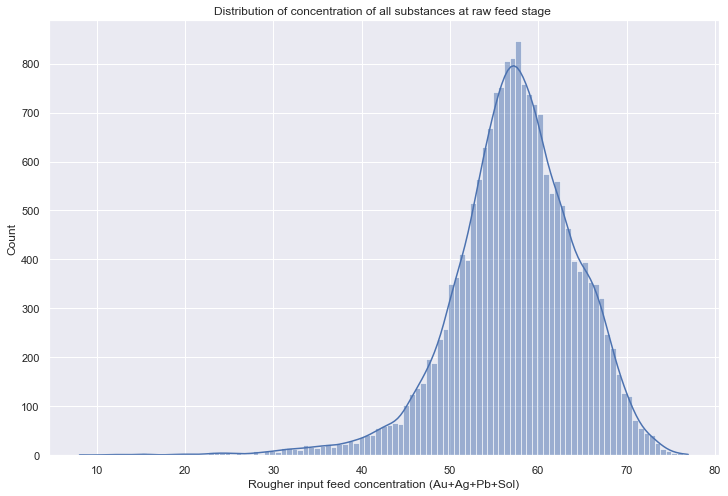

In [76]:
# Plot histogram with raw feed concentrations
sns.set( rc = {'figure.figsize' : ( 12, 8 ), 'axes.labelsize' : 12, 'axes.titlesize':12}) 
ax= sns.histplot(data=full_df['raw_feed.concentration'], kde=True)

ax.set_title('Distribution of concentration of all substances at raw feed stage ')

ax.set_xlabel('Rougher input feed concentration (Au+Ag+Pb+Sol)')
ax.set_ylabel('Count');


In [77]:
#Print statistics for rougher concentration
full_df[[col for col in full_df.columns if 'rougher.output.concentrate' in col]].describe()

,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au
count,18943.000000,18943.000000,18943.000000,18943.000000
mean,12.247708,7.765623,29.390648,20.184020
std,2.126503,1.431919,4.305604,2.443151
min,0.351874,0.214360,0.000000,0.570819
25%,10.712133,6.800822,27.416385,18.922279
50%,12.169738,7.773610,29.911718,20.325784
75%,13.767231,8.585009,32.233851,21.752120
max,24.480271,13.617072,38.351193,28.824507


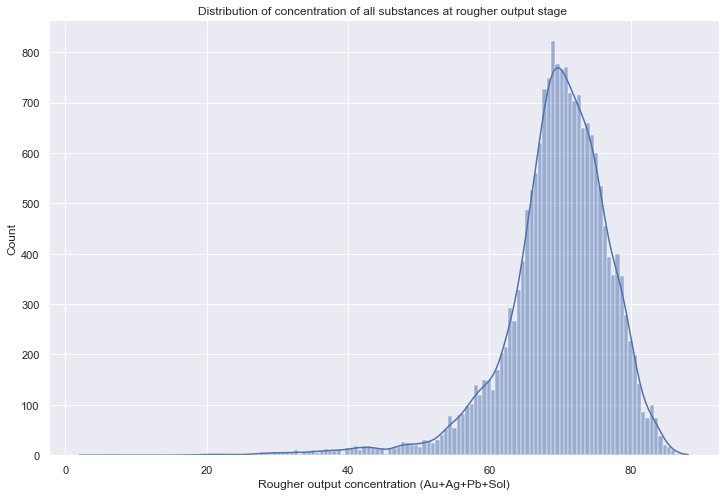

In [78]:

# Plot histogram with rougher output concentrations
sns.set( rc = {'figure.figsize' : ( 12, 8 ), 'axes.labelsize' : 12, 'axes.titlesize':12}) 
ax= sns.histplot(data=full_df['rougher_output.concentration'], kde=True)

ax.set_title('Distribution of concentration of all substances at rougher output stage ')

ax.set_xlabel('Rougher output concentration (Au+Ag+Pb+Sol)')
ax.set_ylabel('Count');



In [79]:
#Print statistics for final output concentration
full_df[[col for col in full_df.columns if 'final.output.concentrate' in col]].describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au
count,18943.000000,18943.000000,18943.000000,18943.000000
mean,5.200285,10.034897,9.478635,44.282879
std,1.326415,1.513247,2.826992,4.029323
min,0.193950,0.332391,0.000000,0.904254
25%,4.271399,9.151371,7.675730,43.416113
50%,5.081187,10.114075,9.207415,45.006961
75%,5.902512,11.051539,10.959542,46.261217
max,16.001945,17.031899,19.615720,52.756638


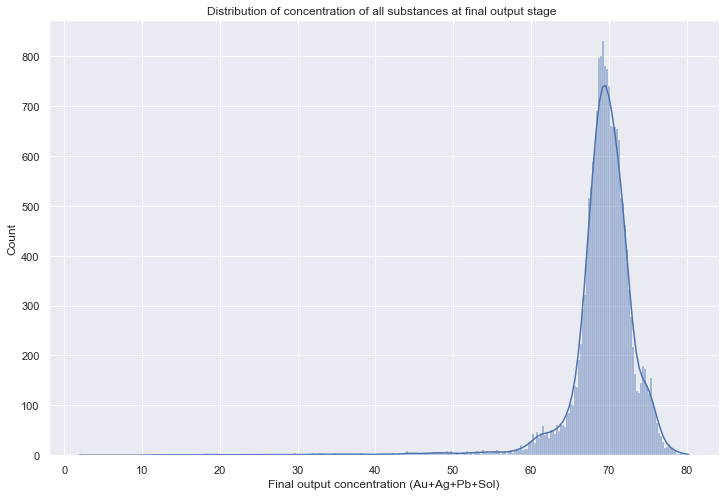

In [80]:
# Plot histogram with final output concentrations
sns.set( rc = {'figure.figsize' : ( 12, 8 ), 'axes.labelsize' : 12, 'axes.titlesize':12}) 
ax= sns.histplot(data=full_df['final_output.concentration'], kde=True)

ax.set_title('Distribution of concentration of all substances at final output stage ')

ax.set_xlabel('Final output concentration (Au+Ag+Pb+Sol)')
ax.set_ylabel('Count');


In [81]:
#drop the columns added

full_df= full_df.drop(['raw_feed.concentration', 'rougher_output.concentration', 'final_output.concentration'], axis=1).copy()

In [82]:
#Redefine train df filtering the same dates in full df (we need to exclude the ones we've dropped out)
train_df_index_ok= [index for index in train_df.index if index in full_df.index]
train_df=full_df.loc[train_df_index_ok,:].copy()
train_df.shape

(13789, 86)

In [83]:
#Redefine test df filtering the same dates in full df (where missing values have been filled out)
test_df_index_ok=[index for index in test_df.index if index in full_df.index]
test_df=full_df.loc[test_df_index_ok,test_df_features].copy()
test_df.shape

(5154, 52)

## 3) Build the model

### 3.1. Write a function to calculate the final sMAPE value.

Below, we'll write two functions to get to final sMAPE value achieved by a ML model:

1) sMAPE:
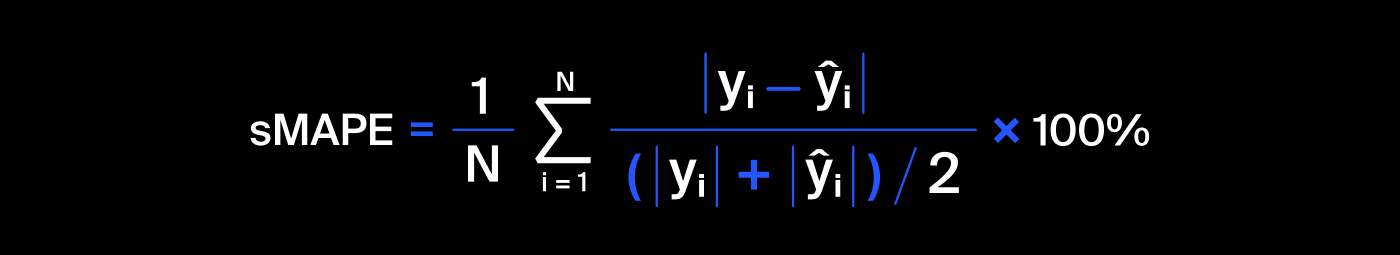

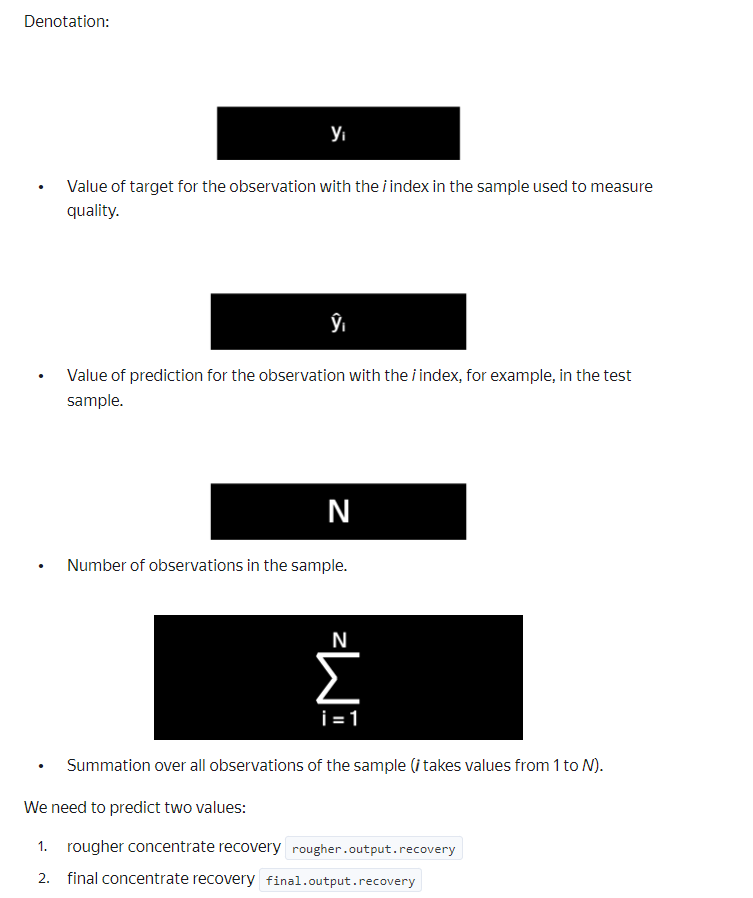

In [84]:
#Define a function to calculate smape of final and rougher recovery predictions

def smape(target, predictions):
    
    ''' Takes two sets containing real outputs and predicted values and
    returns the smape score for the predictions'''
    
    target= pd.Series(target.reset_index(drop=True))
    predictions=pd.Series(predictions[target.index])
    
    
    smape= sum(abs(target-predictions) / ((abs(target)+abs(predictions))/2))*1/len(target)*100
    return smape

2) Final sMAPE:

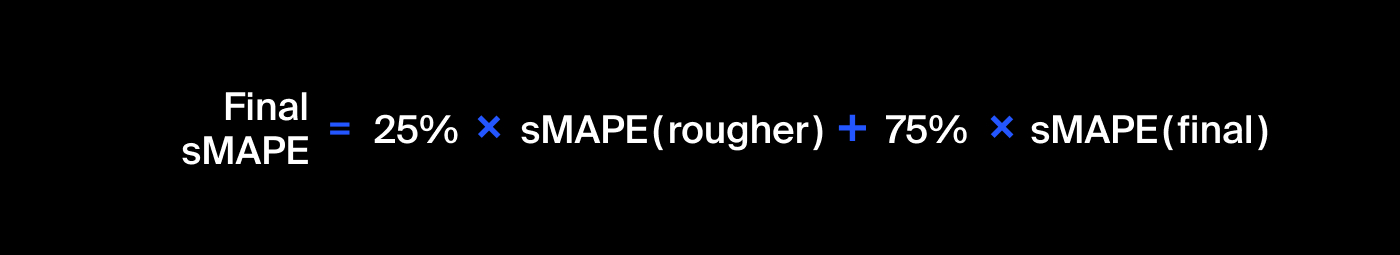

In [85]:
#define formula to get final smape 
def final_smape(target_rougher, predictions_rougher, target_final, predictions_final):
    
    '''takes target and predicted rougher and final recovery
    and retrieves the final sMAPE of the model used for making 
    predictions'''
    
    smape_rougher= smape(target_rougher, predictions_rougher)
    smape_final= smape(target_final, predictions_final)
    
    final_smape = 0.25* smape_rougher + 0.75 *smape_final
    return final_smape

### 3.2. Model evaluation

#### 3.1) Train different models, spliting the train set into train and validation sets.

#### 3.2) Evaluate them using cross-validation. 



In [86]:
#select columns for features 
column_features=test_df.columns


In [87]:
#defina a formula to get the average sMAPE of a model using crossed validation method
def cross_val_smape(model, df):
    '''Takes a model and a dataframe containing gold mining input data, 
    rougher.output.recovery and final.output.recovery
    and retrieves the average sMAPE achieved by the model '''
    df= df.reset_index(drop=True)
    
    #average score of the model
    scores = []

    # set the block size as len/4
    sample_size = int(len(df)/3)
    
    
    for i in range(0, len(df)-sample_size, sample_size):
        valid_indexes = range(i, i+sample_size) # indices for the validation block 
        train_indexes = list(range(0,i))+list(range(i+sample_size, len(df))) #indices for the training set
        
        
        
        # Split variables features and target into samples features_train, target_train, features_valid, target_valid
        features_train = df.loc[train_indexes, column_features]
        features_valid = df.loc[valid_indexes, column_features]
        target_train_rougher = df.loc[train_indexes,'rougher.output.recovery']
        target_train_final= df.loc[train_indexes,'final.output.recovery']
        target_valid_rougher = df.loc[valid_indexes,'rougher.output.recovery']
        target_valid_final = df.loc[valid_indexes,'final.output.recovery']
        

        model_rougher = model
        model_final = model
        
        model_rougher.fit(features_train, target_train_rougher)
        model_final.fit(features_train, target_train_final)
        
        predictions_rougher= model_rougher.predict(features_valid)
        predictions_final= model_final.predict(features_valid)
        
        score = final_smape(target_valid_rougher, predictions_rougher,target_valid_final,predictions_final ) # < evaluate model quality >

        scores.append(score)

    # < calculate average model quality >
    final_score= sum(scores)/len(scores)

    
    
    return final_score

In [88]:
#Get the sMAPE using a linear regression model
model_linear= LinearRegression()
cross_val_smape(model_linear, train_df)

17.231427811360295

In [89]:
#Get the sMAPE of a decision tree regressor, iterating depth from one to five, and choosing the one achieving the lowest score

best_model_tree= None
best_score_tree= 20

for depth in range (1, 5):

    model_tree= DecisionTreeRegressor(random_state=12345, max_depth= depth)
    model_tree_score= cross_val_smape(model_tree, train_df)
    
    if model_tree_score<best_score_tree:
        best_model_tree = model_tree
        best_score_tree= model_tree_score

print('Average model quality score:', best_score_tree, '\nBest model:', best_model_tree )

Average model quality score: 13.607039957124712 
Best model: DecisionTreeRegressor(max_depth=1, random_state=12345)


In [90]:
#Get the sMAPE of a decision tree regressor, 
#iterating n_estimators from 10 to 50 and depth from one to five, and choosing the one achieving the lowest score
best_model_forest= None
best_score_forest= 20
for est in range(10, 51, 10):
    for depth in range (1, 5):

        model_forest = RandomForestRegressor(n_estimators=est, max_depth= depth, random_state=12345)
        model_forest_score= cross_val_smape(model_forest, train_df)
        
        if model_forest_score<best_score_forest:
            best_model_forest=model_forest
            best_score_forest=model_forest_score
print('Average model quality score:',best_score_forest, '\nBest model:', best_model_forest )

Average model quality score: 13.519006581860681 
Best model: RandomForestRegressor(max_depth=1, n_estimators=30, random_state=12345)


Conclusion: the best model turned out to be: RandomForestRegressor(max_depth=1, n_estimators=30, random_state=12345), achieving an average sMAPE of 13.51 on the training set, using crossed validation.

#### 3.3) Test the model using the test sample.


In [91]:
#Separate features and target on the train set:

features_train= train_df.loc[:,column_features]
target_train_rougher=  train_df.loc[:,'rougher.output.recovery']
target_train_final= train_df.loc[:,'final.output.recovery']

features_test= test_df 
target_test_rougher=  full_df.loc[test_df.index,'rougher.output.recovery']
target_test_final= full_df.loc[test_df.index,'final.output.recovery']

model_forest_rougher= RandomForestRegressor(max_depth=2, n_estimators=20, random_state=12345)
model_forest_final= RandomForestRegressor(max_depth=2, n_estimators=20, random_state=12345)

model_forest_rougher.fit(features_train, target_train_rougher)
model_forest_final.fit(features_train, target_train_final)

predictions_rougher= model_forest_rougher.predict(features_test)
predictions_final= model_forest_final.predict(features_test)

score = final_smape(target_test_rougher, predictions_rougher,target_test_final,predictions_final ) 

print('The final sMAPE calculated using the test set was:',score)


The final sMAPE calculated using the test set was: 6.95536095097089


Finally, we will add a comparison of the final model sMAPE score with some simple benchmark: a constant model always predicting mean of the train set targets

In [92]:
#create one model for each target
dummy_regr_rougher = DummyRegressor(strategy="mean")
dummy_regr_final = DummyRegressor(strategy="mean")

#fit train test
dummy_regr_rougher.fit(features_train, target_train_rougher)
dummy_regr_final.fit(features_train, target_train_final)

#predict each target
dummy_predictions_rougher= dummy_regr_rougher.predict(features_test)
dummy_predictions_final= dummy_regr_final.predict(features_test)

#get the model sMAPE score
dummy_score = final_smape(target_test_rougher, dummy_predictions_rougher,target_test_final,dummy_predictions_final ) 



print('The final sMAPE obtained with a baseline model constantly predicting the mean of train set targets would be:',dummy_score)


The final sMAPE obtained with a baseline model constantly predicting the mean of train set targets would be: 7.770478786733959


## Summary/conclusion:

1) After opening and looking into the source dataset (full), we:

- Recalculated recovery for the rougher stage, compared it to the rougher.output.recovery feature and got a mean absolute error  of 0.0, which means it was calculated correctly.

- Analyzed the features not available in the test set, and realized that the missing columns correspond either to outputs, or calculation columns which are not available because they were measured and/or calculated much later.
    What this means, is that at the time of using our model in the future for predicting the amount of gold that will be recovered from ore, those observations won't be available. Hence, we need to train and evaluate models' perfomance, without including those.

- 1.4) Changed date column type to datetime and convert it to the index of every dataframe.

- 1.5) Fixed missing values in the source set, using the inmediately preceeding value in every column other than rougher.output.recovery, which was calculated applying the formula, once the rest of the values were filled out.



2) Data analysis

- 2.1. We analyzed how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage, concluding that:

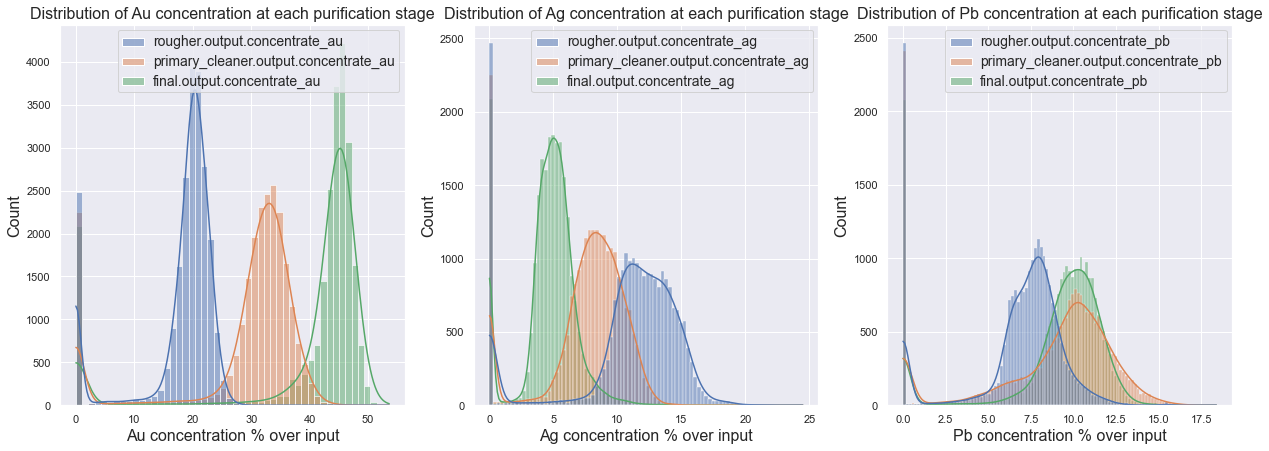
    
    - As we move down the process pipeline, gold percentage (output/input) tends to increase (distributed closely around the 20% in the rougher stage, and around the 45% in the final stage), but silver percentage tends to decrease. Most days, Ag % recovered throughout the final stage was around 5% whereas in the rougher stage it had been between 10 and 17%.

    - Pb (Lead) % is lower at the rougher stage(between 5% and 10%), and similar in the primary and final stages (between 7.5 and 12.5%)

    - There was a considerably high count of days (2500) where metal recovery was close to the 0% at one or more process stages.
    
    

- 2.2. Ensured the feed particle size distributions in the training set and in the test set weren't widely different overall, keeping in mind that if the distributions vary significantly, the model evaluation would be incorrect.

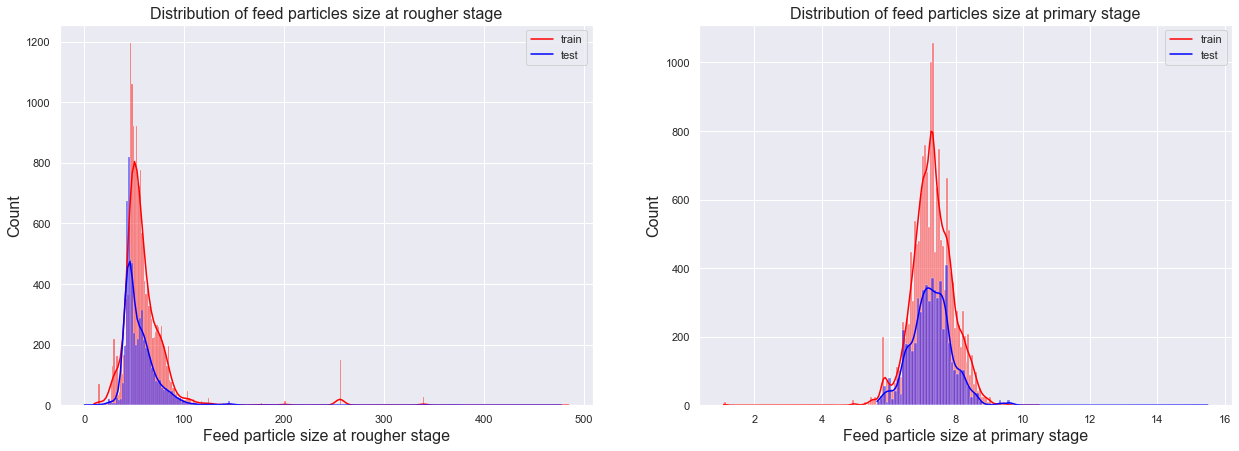


- 2.3. Detected abnormal values in the distribution of the total concentration of all substances at different stages: raw feed, rougher concentrate, and final concentrate. 

At every stage and for all substances, there were around 2000-2500 observations where the sum of concentration of all metals was close to 0. We removed rows where the total concentration of metals at each stage was less than 1 in the source set, and properly redefined the train and test set using only the remaining rows.


3) Model training and evaluation

- 3.1. We wrote a function to calculate the final sMAPE value.

- 3.2. We trained different models, evaluated them using cross-validation and picked the best model: 

**Best model: RandomForestRegressor(max_depth=2, n_estimators=20, random_state=12345)**

**Average sMAPE score (on train set): 13.51**

- **3.3. We tested the model on the test set, and got a final sMAPE of: 6.96**. For reference, we compared it to the one achieved by a constant model always predicting the mean of the train set targets was 7.77.